### You can run this notebook at Colab by clicking here:

<a target="_blank" href="https://colab.research.google.com/github/NMRLipids/databank-template/blob/main/scripts/template.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Initialize NMRlipids databank

In [1]:
import os
import sys
import numpy as np
import json
import matplotlib.pyplot as plt
import urllib.request
import yaml
import random

if 'google.colab' in sys.modules:
  !pip3 install MDAnalysis
import MDAnalysis


# This defines the path for the NMRlipids Databank on your computer.
# Before running this you need to clone the NMRlipids Databank git locally
# from here https://github.com/NMRLipids/Databank
# and install DatabankLib package as it's described

if 'google.colab' in sys.modules:
  !git clone https://github.com/NMRLipids/Databank.git
  databankPath = '/content/Databank'

from DatabankLib.core import *
from DatabankLib.databankLibrary import *

# This initializes the databank and stores the information of all simulations into a list.
# Each list item contains the information from README.yaml file of the given simulation.
systems = initialize_databank()

Databank initialized from the folder: /home/comcon1/repo/Databank/Data/Simulations


# Select random simulation for example and show its content

In [6]:
 ### To exemplify the analysis of any simulation, we select randomly one simulation ID
randomID = random.randint(1, len(systems))
#randomID=546
print('ID of the selected simulation: ', randomID)

# get system by ID
system = systems.loc(randomID)
print_README(system)

ID of the selected simulation:  440
DOI:
  10.5281/zenodo.259354
SOFTWARE:
  gromacs
TRJ:
  [['md20.xtc']]
TPR:
  [['md20.tpr']]
PREEQTIME:
  0
TIMELEFTOUT:
  0
DIR_WRK:
  /usr/home/bort/Databank
PUBLICATION:
  None
AUTHORS_CONTACT:
  Javanainen, Matti
SYSTEM:
  50CHOL_200POPC_9000SOL_73CAL_146CLA_310K
SOFTWARE_VERSION:
  4.6
FF:
  Slipids with ECC-scaled ions (Kohagen)
FF_SOURCE:
  http://www.fos.su.se/~sasha/SLipids/ for lipids and https://bitbucket.org/hseara/ions/ for ions
FF_DATE:
  pre-2020
CPT:
  None
LOG:
  None
TOP:
  [['md20.top']]
COMPOSITION:
  {'CHOL': {'NAME': 'CHL1', 'MAPPING': 'mappingCHOLESTEROLslipid.yaml', 'COUNT': [27, 23]}, 'POPC': {'NAME': 'POPC', 'MAPPING': 'mappingPOPCslipids.yaml', 'COUNT': [100, 100]}, 'SOL': {'NAME': 'SOL', 'MAPPING': 'mappingTIP3PwaterSlipids.yaml', 'COUNT': 9000}, 'CAL': {'NAME': 'CA', 'MAPPING': 'mappingCA.yaml', 'COUNT': 73}, 'CLA': {'NAME': 'CL', 'MAPPING': 'mappingCL.yaml', 'COUNT': 146}}
TRAJECTORY_SIZE:
  1285502428
TRJLENGTH:
  60010

In [3]:
# You always can load the explanation of README content by using 'example' instead of System
print('\n Explanation of simulation content')
print_README('example')


 Explanation of simulation content
DOI:
  DOI from where the raw data is found user given (compulsory).
SOFTWARE:
  Software used to run the simulation (e.g. Gromacs, Amber, NAMD, etc.).
TRJ:
  Name of the trajectory file found from DOI.
TPR:
  Name of the topology file found from DOI (tpr file in the case of Gromacs).
PREEQTIME:
  Pre-equilibrate time simulated before the uploaded trajectory in nanoseconds. For example, if you upload 100-200 ns part of total 200 ns simulation this should value should be 100.
TIMELEFTOUT:
  Equilibration period in the uploaded trajectory that should be discarded in analyses. For example, if you upload 0-200 ns part of total 200 ns simulation where the first 100 ns should be considered as an equilibration, this value should be 100.
UNITEDATOM_DICT:
  Information for constructing hydrogens for united atom simulations, empty for all atom simulations.
COMPOSITION:
  Molecule names used in the simulation and corresponding mapping files. The COMPOSITION is 

# Show analyzed properties stored in the NMRlipids databank for the selected system:

Membrane area per lipid: 50.7045858899819 

Membrane thickness: 4.666698425292969 

Relative equilibration time for each lipid in the simulation:
POPC: 0.3547483874026994


Plot form factor and C-H bond order parameters from the simulation together with experimental data if available 

CHOL
DOI:  10.5281/zenodo.259354
Force field quality not found


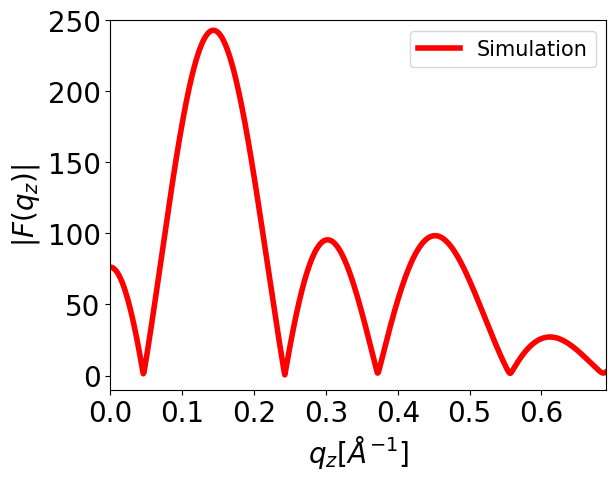

Form factor plotting failed


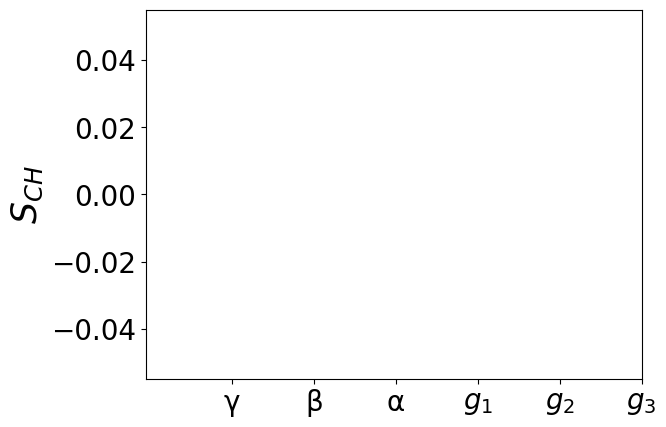

Plotting failed for  CHOL
min() arg is an empty sequence
POPC
DOI:  10.5281/zenodo.259354
Force field quality not found


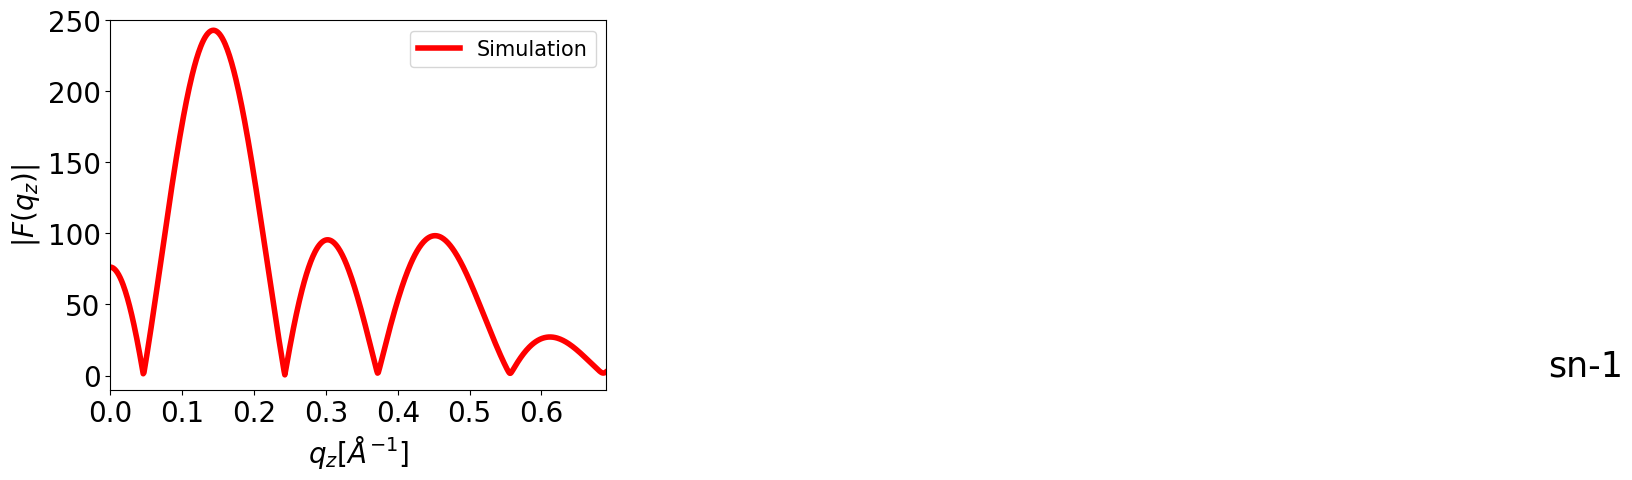

Form factor plotting failed


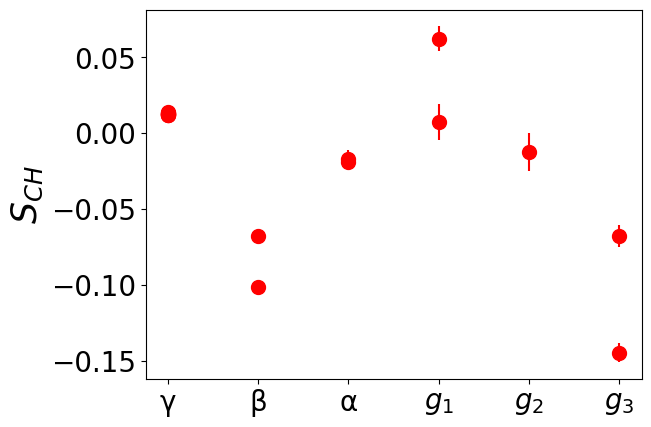

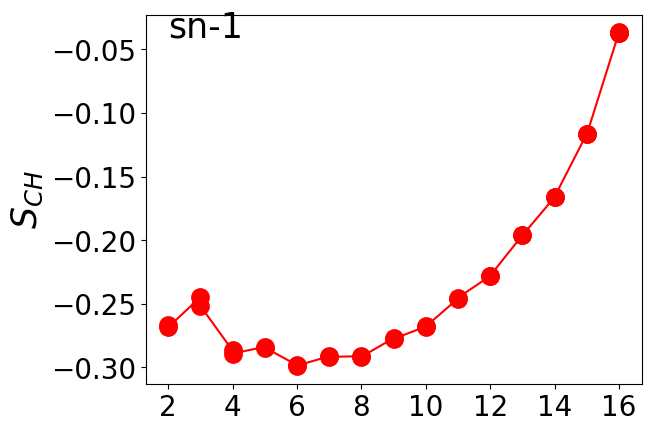

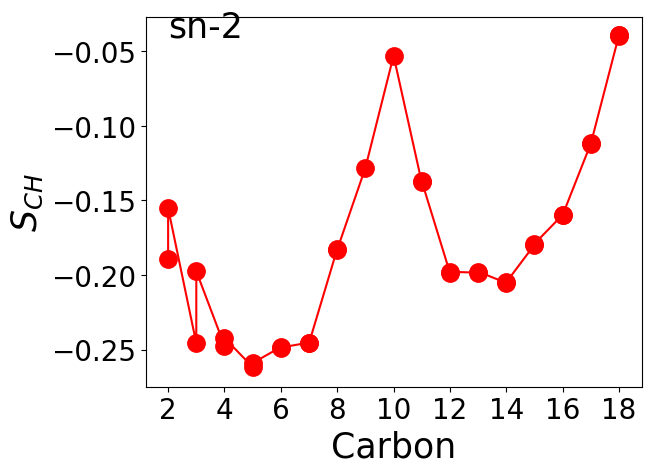

In [7]:
from DatabankLib.plottings import plotSimulation

## Membrane area per lipid, thickness, relative equilibration time, C-H bond order parameters
## and X-ray scattering form factors shown for the selected random simulation.
## We are doing all these things for a randomly picked system (loaded above).

APL = CalcAreaPerMolecule(system)
print('Membrane area per lipid:' , APL, '\n')

thickness = GetThickness(system)
print('Membrane thickness:' , thickness, '\n')

print('Relative equilibration time for each lipid in the simulation:')
ShowEquilibrationTimes(system)
print('\n')

print('Plot form factor and C-H bond order parameters from the simulation together with experimental data if available \n')
for lipid in system['COMPOSITION']:
    if lipid not in lipids_dict:
        continue
    print(lipid)
    try:
        plotSimulation(system, lipid)
    except Exception as e:
        print('Plotting failed for ', lipid)
        print(e)


# Selects a random simulation with the trajectory size below 100Mb and calculates P-N vector angle with respect to membrane normal for all lipids for which P and N atoms are available in headgroup

In [9]:
## Print simulation specific

Patom_UNI = 'M_G3P2_M'   # universal name of phophate headgroup atom
Natom_UNI = 'M_G3N6_M'   # universal name of nitrogen headgroup atom


## Finding a random simulation with smaller than 100Mb trajectory for testing
for i in range(len(systems)):
    randomID = random.randint(1, len(systems))
    system = systems.loc(randomID)
    # This filters out larger than 100Mb trajectories for testing
    if system['TRAJECTORY_SIZE'] < 100000000:
        break

print('ID number of the selected simulation: ', randomID)

# Creates MDAnalysis universe from the simulation
# This will also download simulation files if not yet available locally
MDAuni = system2MDanalysisUniverse(system)

# Loops over molecules and calculates P-N vector angle if atoms are found
for molecule in system['COMPOSITION']:
    if molecule not in lipids_dict:
        continue
    print('\n Analysing ' + molecule)
    Patom_SIM = simulation2universal_atomnames(system,molecule,Patom_UNI)
    #print(Patom_SIM)
    Natom_SIM = simulation2universal_atomnames(system,molecule,Natom_UNI)
    #print(Natom_SIM)
    if Patom_SIM == None or Natom_SIM == None:
        continue

    #print(molecule, Patom_SIM, Natom_SIM)
    resname = system['COMPOSITION'][molecule]['NAME']
    PNangles = read_trj_PN_angles(resname, Patom_SIM, Natom_SIM, MDAuni)

    print('PN vector angle for ' + molecule + ':' + str(PNangles[2]) + ' +/- ' + str(PNangles[3]) + '\n')

ID number of the selected simulation:  661

 Analysing POPC
PN vector angle for POPC:68.48580059066401 +/- 0.42236210360705273


 Analysing CHOL


M_G3P2_M was not found from mappingCHOLESTEROLslipid.yaml!M_G3N6_M was not found from mappingCHOLESTEROLslipid.yaml!